In [ ]:
#---------------------------------------#
# author : https://github.com/vidit1999 #
#---------------------------------------#

In [21]:
import os
import copy
import time
import tqdm
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from google.colab import files
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torchsummary import summary

warnings.filterwarnings('ignore')

%matplotlib inline

In [51]:
seed = 0

np.random.seed(seed)
_ = torch.manual_seed(seed)

In [72]:
torch.backends.cudnn.benchmark = True

device = "cuda" if torch.cuda.is_available() else "cpu"
device_count = torch.cuda.device_count()

train_batch_size = 800
val_batch_size = 100
test_batch_size = 100

latent_size = 50

max_noise_fraction = 0.7

epochs = 20
learning_rate = 0.001

print("Device :", device)
print("GPU Count :", device_count)

Device : cuda
GPU Count : 1


In [64]:
def add_noise(image):
    beta = np.random.uniform()*max_noise_fraction
    return beta*torch.rand_like(image, device=image.device) + (1-beta)*image


transforms = T.Compose(
    [
     T.ToTensor()
    ]
)

noisy_transforms = T.Compose(
    [
     T.RandomApply([T.Lambda(lambd=add_noise)])
    ]
)

In [65]:
class NoisyImageDataset(Dataset):
    def __init__(self, file_path, transforms, noisy_transforms):
        self.df = pd.read_csv(file_path)
        
        if "label" in self.df.columns:
            self.df.drop(["label"], axis=1, inplace=True)

        self.transforms = transforms
        self.noisy_transforms = noisy_transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = self.df.iloc[index].to_numpy(dtype=np.dtype('float32')).reshape(28, 28)/255.0

        image = self.transforms(image)
        noisy_image = self.noisy_transforms(image)
        
        return image, noisy_image

In [66]:
train_set, val_set = random_split(dataset=NoisyImageDataset('./data/mnist_train.csv', transforms, noisy_transforms), lengths=[50000, 10000])
test_set = NoisyImageDataset('./data/mnist_test.csv', transforms, noisy_transforms)

print("Train set length :",len(train_set))
print("Validation set length :", len(val_set))
print("Test set length :", len(test_set))

Train set length : 50000
Validation set length : 10000
Test set length : 10000


In [67]:
data_loader = {
    'train' : DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True, num_workers=4*device_count, pin_memory=True),
    'val' : DataLoader(dataset=val_set, batch_size=val_batch_size, shuffle=False, num_workers=4*device_count, pin_memory=True),
    'test' : DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=False, num_workers=4*device_count, pin_memory=True)
}

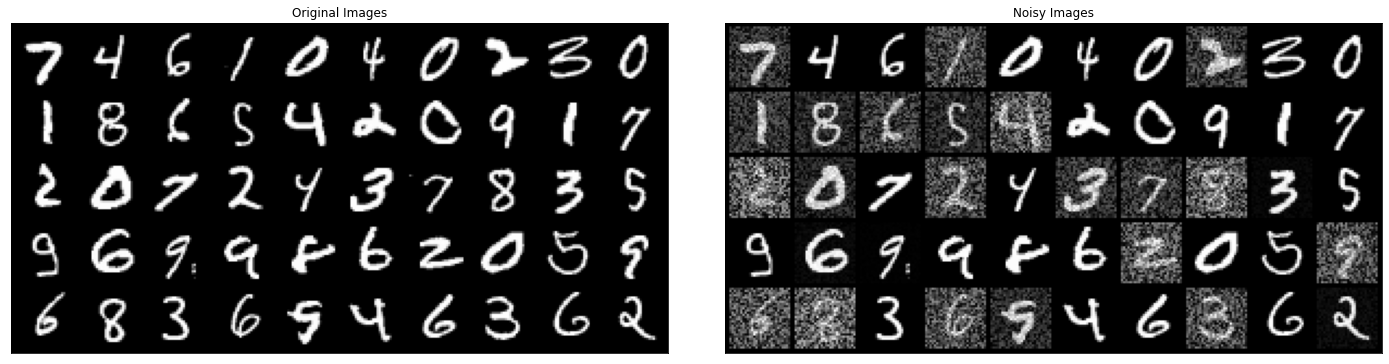

In [68]:
images, noised_images = next(iter(data_loader['train']))


plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.title("Original Images")
plt.imshow(make_grid(images[:50], nrow=10, normalize=True).permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.title("Noisy Images")
plt.imshow(make_grid(noised_images[:50], nrow=10, normalize=True).permute(1, 2, 0))

plt.tight_layout()
plt.show()

In [69]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=224, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=224),

            nn.Conv2d(in_channels=224, out_channels=112, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=112),

            nn.Conv2d(in_channels=112, out_channels=56, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=56),

            nn.Conv2d(in_channels=56, out_channels=16, kernel_size=3, stride=1, padding=1),
        )

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(in_features=1*28*28, out_features=512),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=128, out_features=latent_size),
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=128),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=1024, out_features=1*28*28),
            nn.Sigmoid()
        )
    
    def forward(self, images):
        # pass throuch conv layers
        images = self.encoder_conv_layers(images)

        # flat the images
        images = images.flatten(start_dim=1)
        
        # get the compressed encoded images
        compressed = self.encoder_fc_layers(images)
        
        # get the denoised flat images
        denoised = self.decoder_fc_layers(compressed)
        
        # reshape them
        denoised = denoised.reshape(-1, 1, 28, 28)
        
        return denoised

net = Net().to(device)
summary(net, (1, 28, 28), train_batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [800, 224, 14, 14]           3,808
              ReLU-2         [800, 224, 14, 14]               0
       BatchNorm2d-3         [800, 224, 14, 14]             448
            Conv2d-4           [800, 112, 7, 7]         401,520
              ReLU-5           [800, 112, 7, 7]               0
       BatchNorm2d-6           [800, 112, 7, 7]             224
            Conv2d-7            [800, 56, 7, 7]          56,504
              ReLU-8            [800, 56, 7, 7]               0
       BatchNorm2d-9            [800, 56, 7, 7]             112
           Conv2d-10            [800, 16, 7, 7]           8,080
           Linear-11                 [800, 512]         401,920
             ReLU-12                 [800, 512]               0
           Linear-13                 [800, 256]         131,328
             ReLU-14                 [8

In [70]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [73]:
def train(epochs):
    history = {
        'loss' : {
            'train' : [],
            'val' : []
        }
    }

    width = len(str(epochs))
    best_loss = float('inf')
    best_state_dict = net.state_dict()

    train_start = time.time()
    # ------------------------------------------------
    for e in tqdm.tnrange(1, epochs+1, desc="Epochs"):
        for phase in ['train', 'val']:
            # ============================================
            running_loss = 0
            
            net.train(phase == 'train')
            with torch.set_grad_enabled(phase == 'train'):
                for images, noised_images in data_loader[phase]:
                    # move images to device
                    images, noised_images = images.to(device), noised_images.to(device)

                    # clear the gradients
                    optimizer.zero_grad()

                    # get outputs
                    images_hat = net(noised_images)

                    # get loss
                    loss = F.binary_cross_entropy(images_hat, images, reduction='sum')

                    # adjust variables
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # add to running loss
                    running_loss += loss.item()
                
                history['loss'][phase].append(running_loss / (len(data_loader[phase].dataset) *1*28*28))
            
            # ============================================
        
        # set best test loss value and copy best state dict
        if history['loss']['val'][-1] < best_loss:
            best_loss = history['loss']['val'][-1]
            best_state_dict = copy.deepcopy(net.state_dict())
        
        print(
            f"Epoch[{e:0{width}}/{epochs}] :: "
            f"Train Loss = {history['loss']['train'][-1]:.4f}, "
            f"Validation Loss = {history['loss']['val'][-1]:.4f}"
        )

    # ---------------------------------------------------
    train_end = time.time()

    # load best state dict
    net.load_state_dict(best_state_dict)

    total_time = train_end - train_start

    print(f"\nTotal Time : {total_time:.2f}s")
    
    return total_time, history

In [74]:
total_time, history = train(epochs=epochs)

Epoch[01/20] :: Train Loss = 0.2961, Validation Loss = 0.2501
Epoch[02/20] :: Train Loss = 0.2416, Validation Loss = 0.2297
Epoch[03/20] :: Train Loss = 0.2177, Validation Loss = 0.2016
Epoch[04/20] :: Train Loss = 0.1890, Validation Loss = 0.1776
Epoch[05/20] :: Train Loss = 0.1696, Validation Loss = 0.1617
Epoch[06/20] :: Train Loss = 0.1562, Validation Loss = 0.1503
Epoch[07/20] :: Train Loss = 0.1468, Validation Loss = 0.1427
Epoch[08/20] :: Train Loss = 0.1398, Validation Loss = 0.1383
Epoch[09/20] :: Train Loss = 0.1348, Validation Loss = 0.1343
Epoch[10/20] :: Train Loss = 0.1301, Validation Loss = 0.1278
Epoch[11/20] :: Train Loss = 0.1254, Validation Loss = 0.1271
Epoch[12/20] :: Train Loss = 0.1221, Validation Loss = 0.1213
Epoch[13/20] :: Train Loss = 0.1190, Validation Loss = 0.1193
Epoch[14/20] :: Train Loss = 0.1165, Validation Loss = 0.1165
Epoch[15/20] :: Train Loss = 0.1142, Validation Loss = 0.1148
Epoch[16/20] :: Train Loss = 0.1133, Validation Loss = 0.1144
Epoch[17

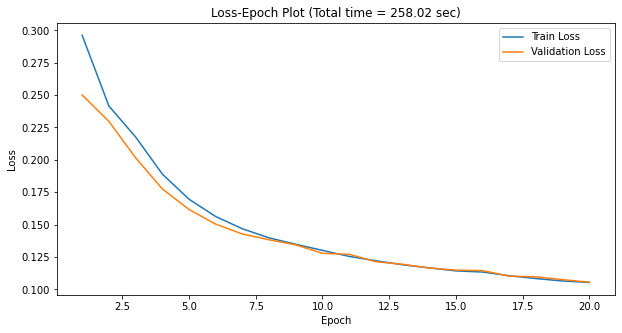

In [75]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), history['loss']['train'], label="Train Loss")
plt.plot(range(1, epochs+1), history['loss']['val'], label="Validation Loss")
plt.title(f"Loss-Epoch Plot (Total time = {total_time:.2f} sec)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss-epoch.png")
plt.show()

In [76]:
net.eval()
with torch.no_grad():
    running_loss = 0
    
    for images, noised_images in tqdm.notebook.tqdm(data_loader['test'], desc="Test"):
        # shift images to device
        images, noised_images = images.to(device), noised_images.to(device)

        # get the output
        images_hat = net(noised_images)

        # get loss
        loss = F.binary_cross_entropy(images_hat, images, reduction='sum')

        # add to running loss
        running_loss += loss.item()
    
    print(f"Test Loss : {running_loss / (len(data_loader['test'].dataset) *1*28*28):.4f}")



Test Loss : 0.1050


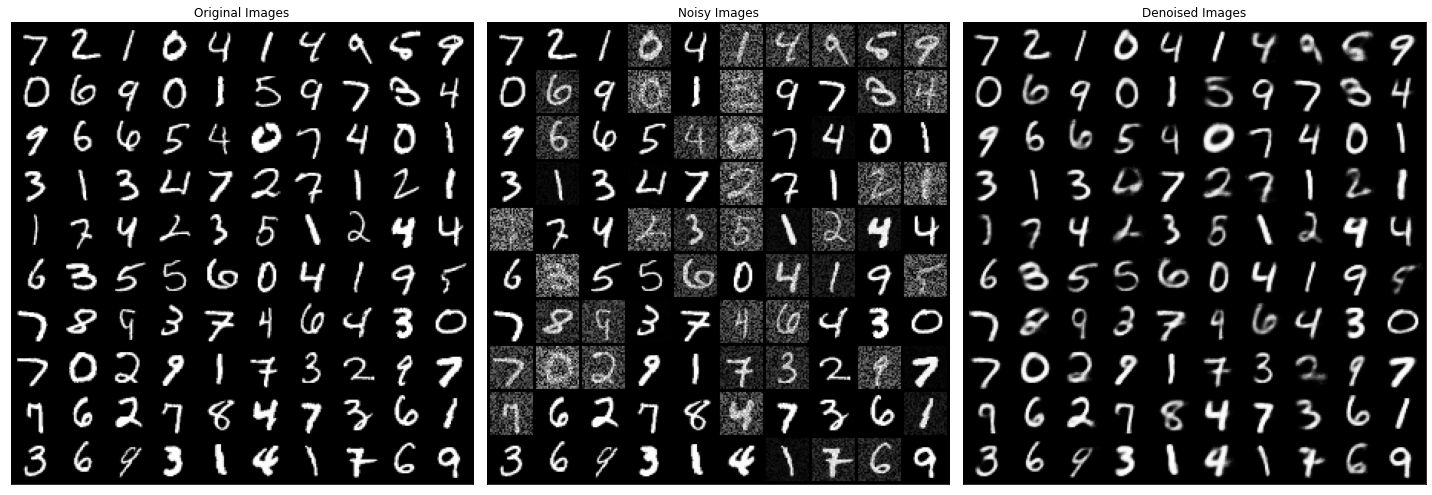

In [77]:
net.eval()
with torch.no_grad():
    images, noised_images = next(iter(data_loader['test']))
    
    images = images
    noised_images = noised_images
    
    images, noised_images = images.to(device), noised_images.to(device)
    
    images_hat = net(noised_images)
    
    plt.figure(figsize=(20, 10))
    
    for i, (data, title) in enumerate(zip((images, noised_images, images_hat), ("Original", "Noisy", "Denoised")), 1):
        plt.subplot(1, 3, i)
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{title} Images")
        plt.imshow(make_grid(data.cpu(), nrow=10, normalize=True).permute(1, 2, 0))
    
    plt.savefig("images-comparison.png")
    plt.tight_layout()
    plt.show()

In [79]:
checkpoint = {
    'net' : {
        'model' : Net(),
        'state_dict' : net.state_dict(),
    },
}
torch.save(checkpoint, 'checkpoint.pth')

In [80]:
files.download("checkpoint.pth")
files.download("loss-epoch.png")
files.download("images-comparison.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>